In [409]:
def get_meta(filename):    
    f = open(filename)
    data = json.load(f)
    return data['currency'], data['regularMarketPrice'], data['regularMarketTime']

def get_change_rate(filename):    
    f = open(filename)
    data = json.load(f)
    return data['regularMarketPrice'], data['regularMarketTime']

In [410]:
# check all directories under ../data
import os
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np

rootdir = '../data'
data_src = []
all_names = ''
for subdir, dirs, files in os.walk(rootdir):
    for dir in dirs:
        obj =  {}
        name = dir
        # get currency.
        currency, cur_price, cur_time = get_meta(os.path.join(subdir, dir, 'meta'))
           
        if currency == '':
            continue
        
        all_names += dir
        
        obj['name'] = dir
        obj['currency'] = currency
        
        left = pd.read_json(os.path.join(subdir, dir, 'data'))
        left['time']=pd.to_datetime(left['timestamp'],unit='s')
        print('left')
        print(left.tail())  
        # to merge currency rate and price
        if currency != 'SEK':
            ex_data_file = os.path.join('../exchange/', currency+'-SEK', 'data')
            ex_meta_file = os.path.join('../exchange/', currency+'-SEK', 'meta')
            right = pd.read_json(ex_data_file)
            change_rate, timestamp = get_change_rate(ex_meta_file)
            print('right')
            print(right.tail())
            
            right['time']=pd.to_datetime(right['timestamp'],unit='s')
            right['close_ex']=right['close']
            df = pd.merge_asof(left, right[['time','close_ex']], on='time')
            df['close']=df['close']*df['close_ex']
            df['high']=df['high']*df['close_ex']
            df['low']=df['low']*df['close_ex']
            df['open']=df['open']*df['close_ex']
            
        else:
            df = left
        
        
        df.dropna(subset = ['close'], inplace=True)
        df['close_log']=np.log(df['close'])
        X = df['time'].astype(np.int64).values.reshape(-1, 1)  # iloc[:, 1] is the column of X
        Y = df['close_log'].values.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        Y_pred = linear_regressor.predict(X)
        obj['scope'] = (Y_pred[-1]-Y_pred[0])/X.shape[0]
        df['close_log_linear']=Y_pred
        df['close_log_error']=df['close_log']-df['close_log_linear']
        obj['df']=df
        data_src.append(obj)

left
          close       high        low       open           timestamp  \
1254  54.529999  56.430000  53.939999  56.220001 2022-01-04 14:30:00   
1255  55.630001  56.439999  55.369999  55.840000 2022-01-05 14:30:00   
1256  54.840000  55.630001  54.490002  55.160000 2022-01-06 14:30:00   
1257  55.720001  55.770000  54.630001  55.360001 2022-01-07 14:30:00   
1258  56.240002  56.259998  54.740002  55.709999 2022-01-10 14:30:00   

        volumn                time  
1254  66993100 2022-01-04 14:30:00  
1255  52956400 2022-01-05 14:30:00  
1256  37000400 2022-01-06 14:30:00  
1257  27686700 2022-01-07 14:30:00  
1258  34025100 2022-01-10 14:30:00  
right
        close     high      low     open           timestamp  volumn
1300  9.09420  9.10705  9.04075  9.09671 2022-01-05 00:00:00     0.0
1301  9.11235  9.16084  9.10362  9.11353 2022-01-06 00:00:00     0.0
1302  9.14530  9.15230  9.05947  9.13930 2022-01-07 00:00:00     0.0
1303  9.05557  9.14795  9.04572  9.05772 2022-01-10 00:00:

right
        close     high      low     open           timestamp  volumn
1300  9.09420  9.10705  9.04075  9.09671 2022-01-05 00:00:00     0.0
1301  9.11235  9.16084  9.10362  9.11353 2022-01-06 00:00:00     0.0
1302  9.14530  9.15230  9.05947  9.13930 2022-01-07 00:00:00     0.0
1303  9.05557  9.14795  9.04572  9.05772 2022-01-10 00:00:00     0.0
1304  9.08955  9.10300  9.06130  9.10290 2022-01-11 13:29:28     0.0
left
            close         high          low         open           timestamp  \
1254  2887.989990  2929.699951  2874.330078  2907.919922 2022-01-04 14:30:00   
1255  2755.500000  2889.989990  2753.760010  2888.399902 2022-01-05 14:30:00   
1256  2754.949951  2798.800049  2731.169922  2739.969971 2022-01-06 14:30:00   
1257  2740.340088  2768.969971  2715.330078  2762.909912 2022-01-07 14:30:00   
1258  2773.389893  2776.389893  2663.290039  2701.560059 2022-01-10 14:30:00   

       volumn                time  
1254  1420000 2022-01-04 14:30:00  
1255  2730900 2022-01-

In [411]:
import hashlib
print(all_names)
portfolio_dir = hashlib.md5(all_names.encode('utf-8')).hexdigest()

PFEAAPLERIC-B.STTSLAAIR.FMRKESSITY-B.STDDAIFTGOOGLAZN.STMSFTINTCHEXA-B.STAMBKAMZN


In [412]:
portfolio_dir

'392cc283e0e76b545ec00b364b9abc0d'

In [413]:
data_src[0]['df'].tail()

,close,high,low,open,timestamp,volumn,time,close_ex,close_log,close_log_linear,close_log_error
1254,496.203924,513.493274,490.835129,511.582356,2022-01-04 14:30:00,66993100,2022-01-04 14:30:00,9.09965,6.206987,5.927676,0.279311
1255,505.910363,513.276643,503.545852,507.820137,2022-01-05 14:30:00,52956400,2022-01-05 14:30:00,9.09420,6.226360,5.927832,0.298527
1256,499.721301,506.920066,496.531992,502.637250,2022-01-06 14:30:00,37000400,2022-01-06 14:30:00,9.11235,6.214051,5.927988,0.286063
1257,509.576122,510.033380,499.607744,506.283809,2022-01-07 14:30:00,27686700,2022-01-07 14:30:00,9.14530,6.233579,5.928144,0.305436
1258,509.285252,509.466333,495.701898,504.485777,2022-01-10 14:30:00,34025100,2022-01-10 14:30:00,9.05557,6.233008,5.928611,0.304397


{'name': 'PFE', 'scope': 0.00022631881281425886, 'std': 0.11754953493458695, 'error': 0.3043972760049911}
{'name': 'AAPL', 'scope': 0.0013623246419237063, 'std': 0.12822176069794486, 'error': 0.10441435264367271}
{'name': 'ERIC-B.ST', 'scope': 0.0006292821448272412, 'std': 0.11164725152007074, 'error': -0.11874307785738747}
{'name': 'TSLA', 'scope': 0.002570058891287341, 'std': 0.533736003466588, 'error': 0.4743864301372511}
{'name': 'AIR.F', 'scope': 0.0002478992370492972, 'std': 0.2437943445781852, 'error': 0.08998292823235499}
{'name': 'MRK', 'scope': 0.00031604295485693814, 'std': 0.13645797318645284, 'error': -0.014675225812188053}
{'name': 'ESSITY-B.ST', 'scope': 0.000255798936808896, 'std': 0.08165981181247091, 'error': -0.06875977976650827}
{'name': 'DDAIF', 'scope': -2.0164629816980743e-05, 'std': 0.23445633790690829, 'error': 0.27847973686248206}
{'name': 'T', 'scope': -0.0002682216488570928, 'std': 0.11148338249993389, 'error': -0.020386135819713935}
{'name': 'GOOGL', 'scope

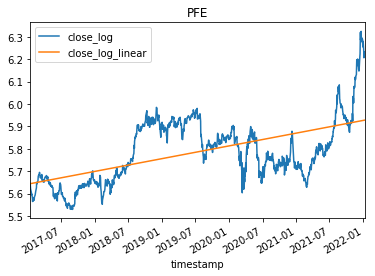

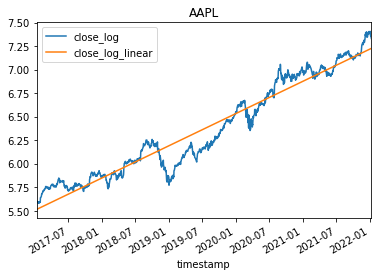

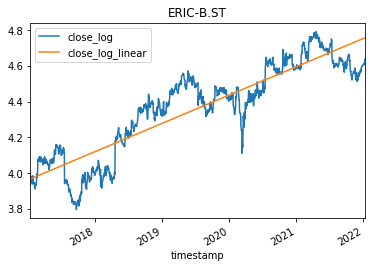

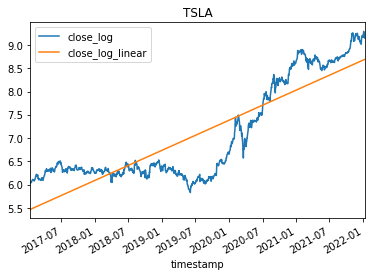

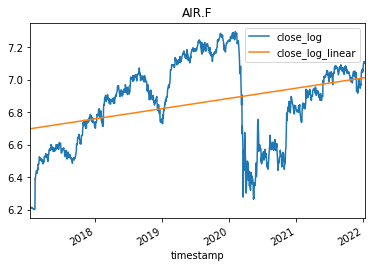

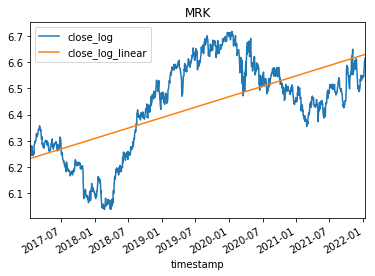

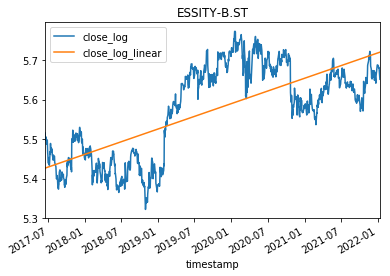

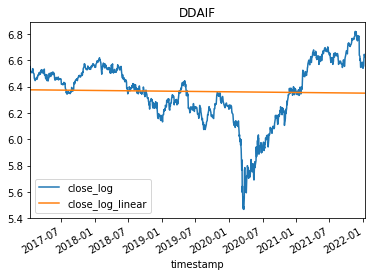

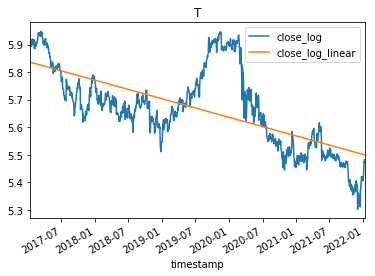

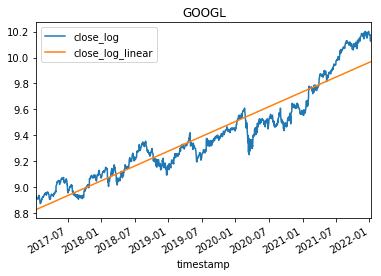

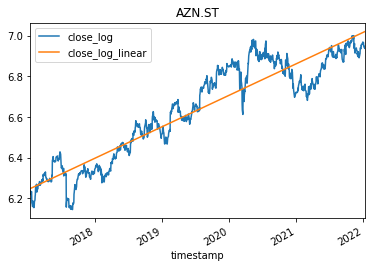

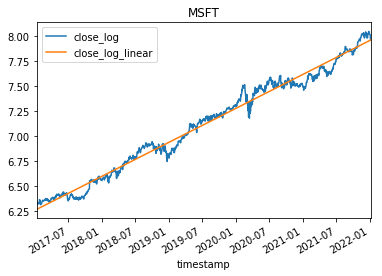

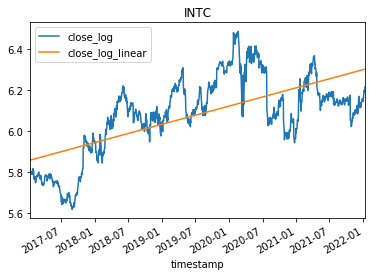

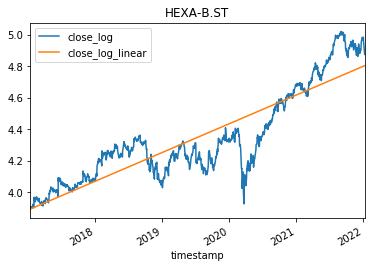

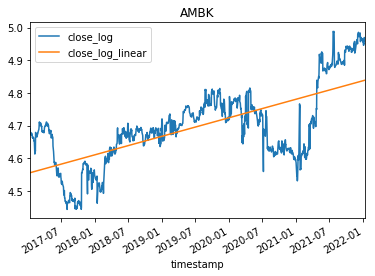

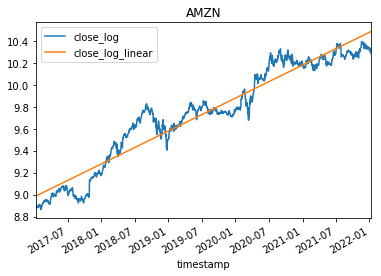

In [414]:
table = []
error_matrix = None
for data in data_src:
    data['df'].plot(x='timestamp', y=['close_log','close_log_linear'], title=data['name'])
    row = {}
    row['name']=data['name']
    row['scope']=data['scope'][0]
    row['std']=data['df']['close_log_error'].std()
    row['error']=data['df']['close_log_error'].values[-1]
    if error_matrix is None:
        error_matrix = data['df'][['time','close_log_error']].rename(columns={'close_log_error': data['name']})
    else:
        error_matrix = pd.merge_asof(error_matrix, data['df'][['time','close_log_error']].rename(columns={'close_log_error': data['name']}), on='time')
    print(row)
    table.append(row)
table = pd.DataFrame(table)

In [415]:
table.tail()

,error,name,scope,std
11,-0.009358,MSFT,0.001350,0.062865
12,-0.087818,INTC,0.000353,0.143009
13,0.084708,HEXA-B.ST,0.000726,0.135788
14,0.120998,AMBK,0.000226,0.088470
15,-0.205394,AMZN,0.001194,0.122817


In [416]:
error_matrix.tail()

,time,PFE,AAPL,ERIC-B.ST,TSLA,AIR.F,MRK,ESSITY-B.ST,DDAIF,T,GOOGL,AZN.ST,MSFT,INTC,HEXA-B.ST,AMBK,AMZN
1251,2022-01-04 14:30:00,0.279311,0.179251,-0.143070,0.572767,0.097187,-0.075800,-0.035015,0.259277,-0.048118,0.210619,-0.068011,0.046908,-0.119717,0.153564,0.114007,-0.158912
1252,2022-01-05 14:30:00,0.298527,0.150754,-0.147688,0.515445,0.094164,-0.052624,-0.038937,0.278711,-0.026545,0.162432,-0.070931,0.006235,-0.106916,0.147048,0.113252,-0.179406
1253,2022-01-06 14:30:00,0.286063,0.134976,-0.147688,0.493911,0.093689,-0.051482,-0.038937,0.294912,-0.028190,0.163600,-0.070931,-0.000633,-0.102570,0.147048,0.127870,-0.184968
1254,2022-01-07 14:30:00,0.305436,0.138636,-0.147556,0.459662,0.093372,-0.029614,-0.038607,0.287939,-0.017525,0.161266,-0.076597,0.002557,-0.109813,0.115410,0.131324,-0.186477
1255,2022-01-10 14:30:00,0.304397,0.138636,-0.138536,0.474386,0.098803,-0.014675,-0.057717,0.278480,-0.020386,0.161516,-0.082709,-0.009358,-0.087818,0.070906,0.120998,-0.205394


In [417]:
error_matrix.cov()

,PFE,AAPL,ERIC-B.ST,TSLA,AIR.F,MRK,ESSITY-B.ST,DDAIF,T,GOOGL,AZN.ST,MSFT,INTC,HEXA-B.ST,AMBK,AMZN
PFE,0.013818,-0.004207,0.003069,-0.027410,0.014578,0.007059,-0.000163,0.001057,0.000384,0.003311,0.002521,0.002769,0.003280,0.000092,0.006097,0.001989
AAPL,-0.004207,0.016447,-0.002074,0.049490,-0.012036,-0.006616,-0.001595,0.009270,-0.001946,0.005866,-0.001002,0.002214,-0.006837,0.008626,-0.001533,0.000743
ERIC-B.ST,0.003069,-0.002074,0.012502,-0.016424,0.006591,0.006474,0.000495,-0.002653,0.001459,-0.002103,0.002450,0.000651,0.003779,-0.001787,0.000717,0.006648
TSLA,-0.027410,0.049490,-0.016424,0.284874,-0.077548,-0.048881,-0.021197,0.063553,-0.030376,0.024641,-0.023197,-0.007513,-0.049710,0.042655,-0.012463,-0.015802
AIR.F,0.014578,-0.012036,0.006591,-0.077548,0.059564,0.009722,0.001865,0.013418,0.008109,0.005480,0.002324,0.002025,0.013735,0.004497,0.007833,0.002225
MRK,0.007059,-0.006616,0.006474,-0.048881,0.009722,0.018621,0.006945,-0.018944,0.010215,-0.005438,0.008561,0.003376,0.008317,-0.012368,0.003757,0.001104
ESSITY-B.ST,-0.000163,-0.001595,0.000495,-0.021197,0.001865,0.006945,0.006700,-0.010024,0.006754,-0.003083,0.004604,0.002259,0.004780,-0.006596,0.000572,-0.000624
DDAIF,0.001057,0.009270,-0.002653,0.063553,0.013418,-0.018944,-0.010024,0.054970,-0.010694,0.019266,-0.012218,-0.003219,-0.014945,0.027582,0.004075,-0.007916
T,0.000384,-0.001946,0.001459,-0.030376,0.008109,0.010215,0.006754,-0.010694,0.012429,-0.002529,0.005553,0.002648,0.008012,-0.007786,0.002820,-0.002181
GOOGL,0.003311,0.005866,-0.002103,0.024641,0.005480,-0.005438,-0.003083,0.019266,-0.002529,0.012000,-0.002183,0.001754,-0.004044,0.011103,0.004941,-0.002651


In [418]:
table['annual']=table['scope']*252-table['error']

In [419]:
table

,error,name,scope,std,annual
0,0.304397,PFE,0.000226,0.117550,-0.247365
1,0.104414,AAPL,0.001362,0.128222,0.238891
2,-0.118743,ERIC-B.ST,0.000629,0.111647,0.277322
3,0.474386,TSLA,0.002570,0.533736,0.173268
4,0.089983,AIR.F,0.000248,0.243794,-0.027512
5,-0.014675,MRK,0.000316,0.136458,0.094318
6,-0.068760,ESSITY-B.ST,0.000256,0.081660,0.133221
7,0.278480,DDAIF,-0.000020,0.234456,-0.283561
8,-0.020386,T,-0.000268,0.111483,-0.047206
9,0.161516,GOOGL,0.000910,0.109543,0.067747


In [431]:
def get_exp(weights):
    weights = np.array(weights)
    annual_profits = table['annual'].to_numpy()
    res = np.matmul(weights, annual_profits)
    return np.matmul(weights, annual_profits)

In [432]:
def get_std(weights):
    weights = np.array(weights)
    cov_m = np.array(error_matrix.cov())
    res = np.sqrt(np.matmul(np.matmul(weights, cov_m), np.transpose(weights)))
    return np.sqrt(np.matmul(np.matmul(weights, cov_m), np.transpose(weights)))

In [433]:
def get_sharpe(weights):
    print(weights)
    res = -get_exp(weights)/get_std(weights)
    print(res)
    return res

In [434]:
num_stocks=len(table)
bnds = []
init = []
for i in range(num_stocks):
    bnds.append((0,0.3))
    init.append(1/num_stocks)

bnds = tuple(bnds)
init = tuple(init)

In [435]:
from scipy.optimize import minimize

cons = {'type': 'eq', 'fun': lambda x:  1-np.sum(x)}
res = minimize(get_sharpe, init, method='SLSQP', bounds=bnds,
               constraints=cons)

[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
-2.1586274179575975
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
-2.1586274179575975
[0.06250001 0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ]
-2.1586273176927775
[0.0625     0.06250001 0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ]
-2.1586274444908296
[0.0625     0.0625     0.06250001 0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ]
-2.1586274862990114
[0.0625     0.0625     0.0625     0.06250001 0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.062

-6.197376899011971
[1.38038680e-13 1.47029555e-15 8.25896030e-02 5.97225083e-02
 4.95780294e-02 1.53860760e-15 1.37923100e-01 2.24818302e-13
 2.19774154e-14 2.38462916e-04 1.48755865e-01 3.00000000e-01
 1.59787272e-15 2.54459814e-02 6.22338060e-14 1.95746465e-01]
-6.197376908747161
[1.38038680e-13 1.47029555e-15 8.25896030e-02 5.97225083e-02
 4.95780294e-02 1.53860760e-15 1.37923100e-01 2.24818302e-13
 2.19774154e-14 2.38462916e-04 1.48755850e-01 3.00000015e-01
 1.59787272e-15 2.54459814e-02 6.22338060e-14 1.95746465e-01]
-6.197376939912993
[1.38038680e-13 1.47029555e-15 8.25896030e-02 5.97225083e-02
 4.95780294e-02 1.53860760e-15 1.37923100e-01 2.24818302e-13
 2.19774154e-14 2.38462916e-04 1.48755850e-01 3.00000000e-01
 1.49011628e-08 2.54459814e-02 6.22338060e-14 1.95746465e-01]
-6.197376903775011
[1.38038680e-13 1.47029555e-15 8.25896030e-02 5.97225083e-02
 4.95780294e-02 1.53860760e-15 1.37923100e-01 2.24818302e-13
 2.19774154e-14 2.38462916e-04 1.48755850e-01 3.00000000e-01
 1.597

-6.304280407694625
[7.13509104e-14 2.76568794e-14 9.22435565e-02 5.06717399e-02
 2.44576107e-02 2.47954408e-14 2.58130330e-01 2.88689625e-15
 3.34959903e-14 4.69236532e-16 2.39656902e-02 3.00000000e-01
 1.49011900e-08 4.46855303e-02 2.50990977e-14 2.05845542e-01]
-6.304280375038726
[7.13509104e-14 2.76568794e-14 9.22435565e-02 5.06717399e-02
 2.44576107e-02 2.47954408e-14 2.58130330e-01 2.88689625e-15
 3.34959903e-14 4.69236532e-16 2.39656902e-02 3.00000000e-01
 2.87960389e-14 4.46855452e-02 2.50990977e-14 2.05845542e-01]
-6.304280385494315
[7.13509104e-14 2.76568794e-14 9.22435565e-02 5.06717399e-02
 2.44576107e-02 2.47954408e-14 2.58130330e-01 2.88689625e-15
 3.34959903e-14 4.69236532e-16 2.39656902e-02 3.00000000e-01
 2.87960389e-14 4.46855303e-02 1.49011863e-08 2.05845542e-01]
-6.304280353967969
[7.13509104e-14 2.76568794e-14 9.22435565e-02 5.06717399e-02
 2.44576107e-02 2.47954408e-14 2.58130330e-01 2.88689625e-15
 3.34959903e-14 4.69236532e-16 2.39656902e-02 3.00000000e-01
 2.879

In [436]:
table

,error,name,scope,std,annual,percentage
0,0.304397,PFE,0.000226,0.117550,-0.247365,0.000000
1,0.104414,AAPL,0.001362,0.128222,0.238891,0.000000
2,-0.118743,ERIC-B.ST,0.000629,0.111647,0.277322,0.091587
3,0.474386,TSLA,0.002570,0.533736,0.173268,0.050979
4,0.089983,AIR.F,0.000248,0.243794,-0.027512,0.025102
5,-0.014675,MRK,0.000316,0.136458,0.094318,0.000000
6,-0.068760,ESSITY-B.ST,0.000256,0.081660,0.133221,0.255627
7,0.278480,DDAIF,-0.000020,0.234456,-0.283561,0.000000
8,-0.020386,T,-0.000268,0.111483,-0.047206,0.000000
9,0.161516,GOOGL,0.000910,0.109543,0.067747,0.000000


In [437]:
res

     fun: -6.304340075864874
     jac: array([ 7.01310784,  3.24372196,  0.44713026,  0.44399309,  0.44573176,
        1.11412549,  0.44297469,  3.36855531,  3.06966966,  1.01441163,
        0.44523722, -1.04062432,  1.153225  ,  0.44691485,  2.57077628,
        0.44963098])
 message: 'Optimization terminated successfully.'
    nfev: 260
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.        , 0.        , 0.09158712, 0.05097945, 0.02510215,
       0.        , 0.25562704, 0.        , 0.        , 0.        ,
       0.02700698, 0.3       , 0.        , 0.04396872, 0.        ,
       0.20572854])

In [438]:
table['percentage']=res.x
table.style.format({'percentage': '{:.2f}'})

,error,name,scope,std,annual,percentage
0,0.304397,PFE,0.000226319,0.11755,-0.247365,0.00
1,0.104414,AAPL,0.00136232,0.128222,0.238891,0.00
2,-0.118743,ERIC-B.ST,0.000629282,0.111647,0.277322,0.09
3,0.474386,TSLA,0.00257006,0.533736,0.173268,0.05
4,0.0899829,AIR.F,0.000247899,0.243794,-0.0275123,0.03
5,-0.0146752,MRK,0.000316043,0.136458,0.0943181,0.00
6,-0.0687598,ESSITY-B.ST,0.000255799,0.0816598,0.133221,0.26
7,0.27848,DDAIF,-2.01646e-05,0.234456,-0.283561,0.00
8,-0.0203861,T,-0.000268222,0.111483,-0.0472057,0.00
9,0.161516,GOOGL,0.000909772,0.109543,0.0677466,0.00


In [439]:
table

,error,name,scope,std,annual,percentage
0,0.304397,PFE,0.000226,0.117550,-0.247365,0.000000
1,0.104414,AAPL,0.001362,0.128222,0.238891,0.000000
2,-0.118743,ERIC-B.ST,0.000629,0.111647,0.277322,0.091587
3,0.474386,TSLA,0.002570,0.533736,0.173268,0.050979
4,0.089983,AIR.F,0.000248,0.243794,-0.027512,0.025102
5,-0.014675,MRK,0.000316,0.136458,0.094318,0.000000
6,-0.068760,ESSITY-B.ST,0.000256,0.081660,0.133221,0.255627
7,0.278480,DDAIF,-0.000020,0.234456,-0.283561,0.000000
8,-0.020386,T,-0.000268,0.111483,-0.047206,0.000000
9,0.161516,GOOGL,0.000910,0.109543,0.067747,0.000000


In [440]:
get_exp(res.x)

0.28706571757603694

In [441]:
get_std(res.x)

0.04553461807604902

In [442]:
get_sharpe(res.x)

[0.         0.         0.09158712 0.05097945 0.02510215 0.
 0.25562704 0.         0.         0.         0.02700698 0.3
 0.         0.04396872 0.         0.20572854]
-6.304340075864874


-6.304340075864874

In [ ]:
# [{timestamp:1231,sharpe: 6, portofolio: 
# [{symbol:AAPL: percentage:0.21}, {{symbol:AAPL: percentage:0.21}}]}]

def createDir(dir):
    isExist = os.path.exists(dir)
    if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path)



In [ ]:
createDir('../result/')